In [8]:
import os

import pandas as pd
import timm
import torch
import pytorch_lightning as pl
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
# from models.model import FastSiam, fastsiam_convnextv2_nano
from utils.embeddings import extract_embeddings
import lightly
from torch import nn

In [9]:
# Have to put this in here cuz I was dumb and created my cleaned up model creator functions after training them 🙃
# Ideally you would just use the model creator functions in models/model.py, e.g. model = fastsiam_convnextv2_nano()
class FastSiam(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # create a ConvNeXt model without the fc layer head
        # self.backbone = timm.create_model("convnext_nano", num_classes=0)
        self.backbone = timm.create_model("convnextv2_nano", num_classes=0)
        # Original paper uses dimension d=2048. We use 1024 here for lower complexity.
        self.projection_head = SimSiamProjectionHead(640, 1024, 1024)
        # prediction MLP’s hidden layer dimension is always 1/4 of the output dimension
        self.prediction_head = SimSiamPredictionHead(1024, 256, 1024)
        self.criterion = NegativeCosineSimilarity()

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        # Unpack augmented views
        views, _, _ = batch
        x1, x2, x3, x4 = views

        # Pass each view through projector to get z, and predictor to get p
        z1, p1 = self.forward(x1)
        z2, p2 = self.forward(x2)
        z3, p3 = self.forward(x3)
        z4, p4 = self.forward(x4)

        # Use mean of the last N - 1 projected views
        mean = (z2 + z3 + z4) / 3

        # Compute loss using prediction of 1st view, mean of remaining projected views
        loss = self.criterion(p1, mean)

        # Keep a log of the loss
        self.log("loss", loss)
        # Monitor the STD of L2-normalized representation to check if it collapses (bad)

        return loss

    def configure_optimizers(self):
        # FastSiam authors use lr=0.125 (?!), SimSiam would use 0.00625 here. 0.06 is a happy medium :)
        optim = torch.optim.SGD(self.parameters(), lr=0.06)
        return optim

Extracting embeddings for train_1 data


100%|██████████| 623/623 [00:22<00:00, 27.91it/s]


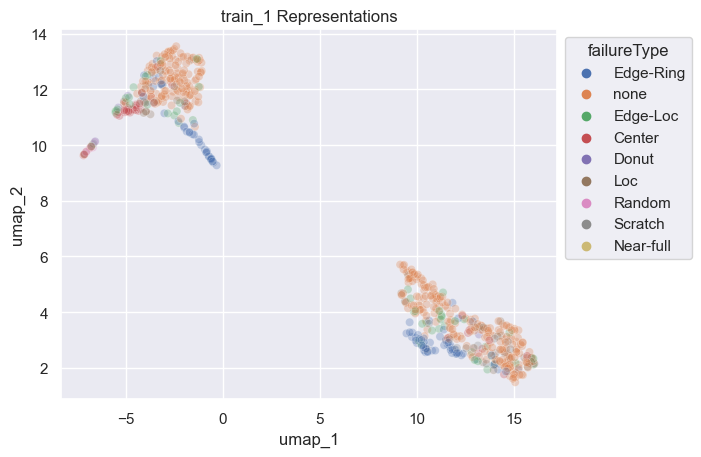

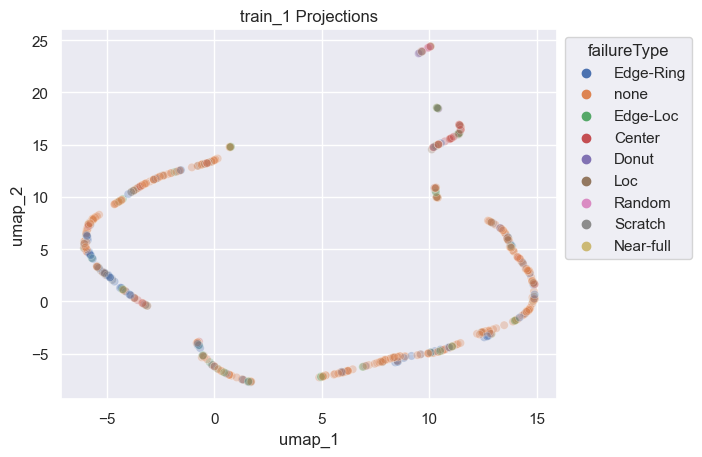

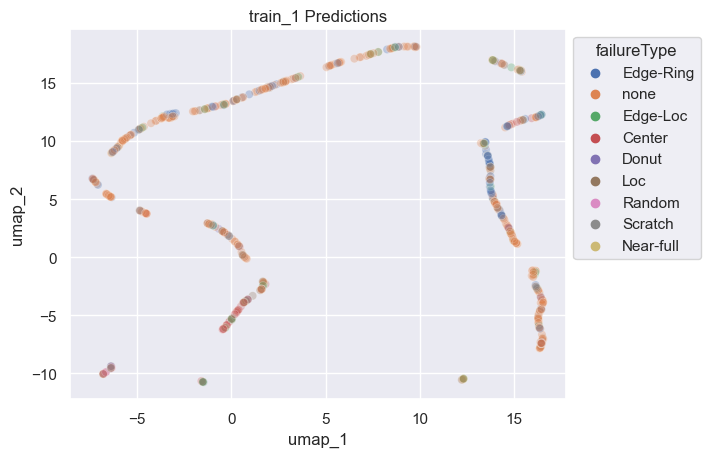

Extracting embeddings for train_10 data


100%|██████████| 6225/6225 [03:25<00:00, 30.32it/s]


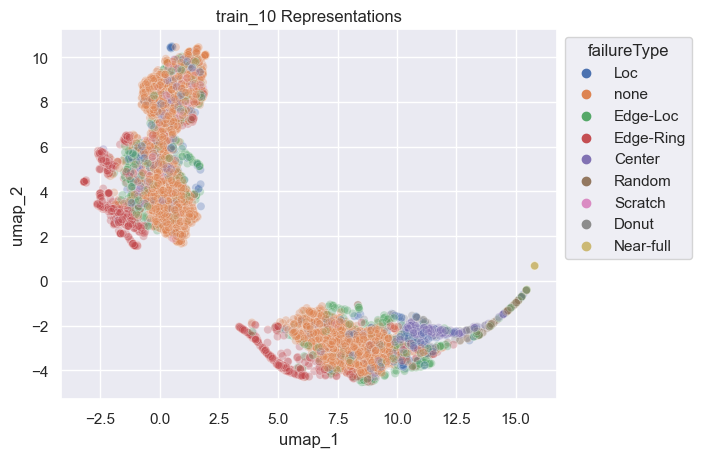

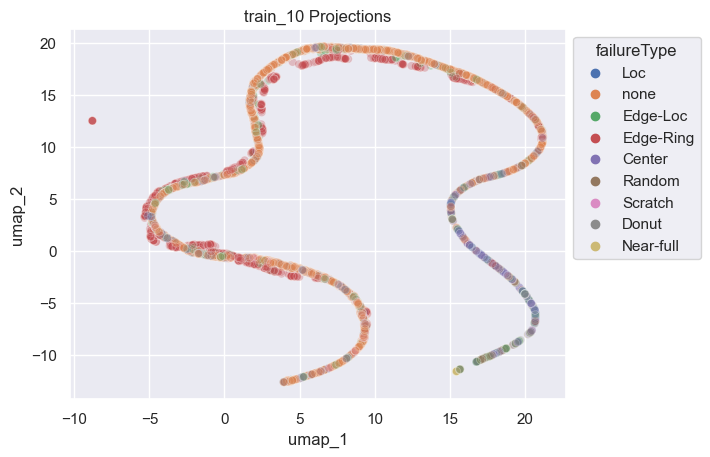

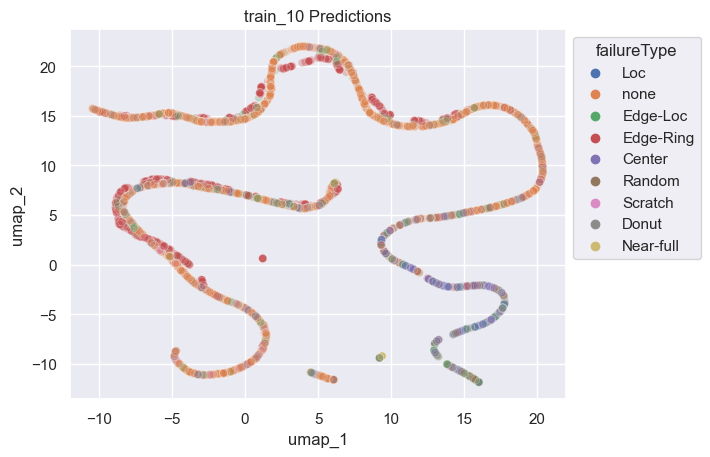

Extracting embeddings for train_20 data


 28%|██▊       | 3435/12449 [02:00<05:01, 29.89it/s]

In [10]:
# Create and load FastSiam model from checkpoint
# model = fastsiam_convnextv2_nano() # correct way to do it...
model = FastSiam()
ckpt_path = "lightning_logs/convnextv2_nano_10/checkpoints/epoch=9-step=7780.ckpt"
model = model.load_from_checkpoint(ckpt_path)
model.eval()

# Load data splits
train_1_split = pd.read_pickle("../data/cleaned_splits/train_1_split.pkl")
train_10_split = pd.read_pickle("../data/cleaned_splits/train_10_split.pkl")
train_20_split = pd.read_pickle("../data/cleaned_splits/train_20_split.pkl")
val_data = pd.read_pickle("../data/cleaned_splits/val_data.pkl")
test_data = pd.read_pickle("../data/cleaned_splits/test_data.pkl")

# Create dictionary of data splits to easily get names for saved files
datasets = {
    "train_1": train_1_split,
    "train_10": train_10_split,
    "train_20": train_20_split,
    "val": val_data,
    "test": test_data,
}

# Extract embeddings for each data split and save to file
save_dir = "../data/embeddings/fastsiam_convnextv2_nano_10"
for name, data in datasets.items():
    print(f"Extracting embeddings for {name} data")
    extract_embeddings(model, data, save_dir, name=name)

In [ ]:
class FastSiam(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # create a ResNet backbone and remove the classification head
        # See https://github.com/lightly-ai/lightly/blob/7d3bc64ac3372c6e7ec8e24a8c56fb499209957f/lightly/models/resnet.py
        resnet = lightly.models.ResNetGenerator("resnet-18")
        self.backbone = nn.Sequential(
            *list(resnet.children())[:-1], nn.AdaptiveAvgPool2d(1)
        )
        # Original paper uses dimension d=2048. We use 1024 here for lower complexity.
        self.projection_head = SimSiamProjectionHead(512, 1024, 1024)
        # prediction MLP’s hidden layer dimension is always 1/4 of the output dimension
        self.prediction_head = SimSiamPredictionHead(1024, 256, 1024)
        self.criterion = NegativeCosineSimilarity()

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        # Unpack augmented views
        views, _, _ = batch
        x1, x2, x3, x4 = views

        # Pass each view through projector to get z, and predictor to get p
        z1, p1 = self.forward(x1)
        z2, p2 = self.forward(x2)
        z3, p3 = self.forward(x3)
        z4, p4 = self.forward(x4)

        # Use mean of the last N - 1 projected views
        mean = (z2 + z3 + z4) / 3

        # Compute loss using prediction of 1st view, mean of remaining projected views
        loss = self.criterion(p1, mean)

        # Keep a log of the loss
        self.log("loss", loss)

        return loss

    def configure_optimizers(self):
        # FastSiam authors use lr=0.125 (?!), SimSiam would use 0.00625 here. 0.06 is a happy medium :)
        optim = torch.optim.SGD(self.parameters(), lr=0.06)
        return optim

Global seed set to 0


Extracting embeddings for train_1 data


100%|██████████| 623/623 [00:51<00:00, 12.07it/s]


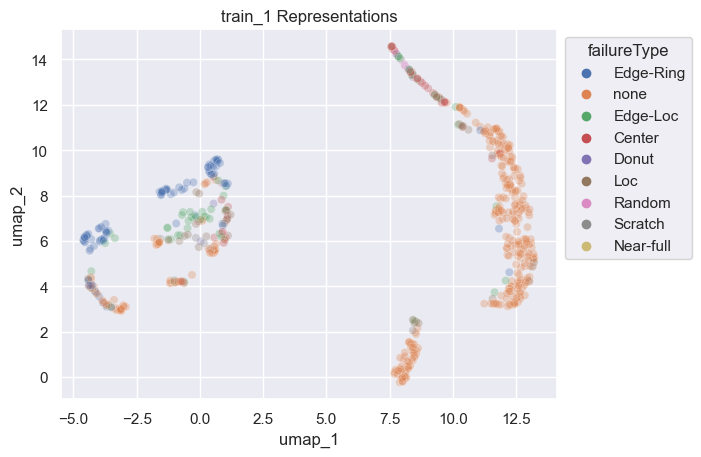

OSError: Cannot save file into a non-existent directory: 'data\umap'

In [ ]:
ckpt_path = "lightning_logs/version_8/checkpoints/epoch=9-step=15560.ckpt"
model = FastSiam.load_from_checkpoint(ckpt_path)
# Extract embeddings for each data split and save to file
save_dir = "../data/embeddings/fastsiam_r18_lightly_10"
for name, data in datasets.items():
    print(f"Extracting embeddings for {name} data")
    extract_embeddings(model, data, save_dir, name=name)

In [ ]:
class FastSiam(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # create a ConvNeXt model without the fc layer head
        # self.backbone = timm.create_model("convnext_nano", num_classes=0)
        self.backbone = timm.create_model("resnet18", num_classes=0)
        # Original paper uses dimension d=2048. We use 1024 here for lower complexity.
        self.projection_head = SimSiamProjectionHead(512, 1024, 1024)
        # prediction MLP’s hidden layer dimension is always 1/4 of the output dimension
        self.prediction_head = SimSiamPredictionHead(1024, 256, 1024)
        self.criterion = NegativeCosineSimilarity()

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        # Unpack augmented views
        views, _, _ = batch
        x1, x2, x3, x4 = views

        # Pass each view through projector to get z, and predictor to get p
        z1, p1 = self.forward(x1)
        z2, p2 = self.forward(x2)
        z3, p3 = self.forward(x3)
        z4, p4 = self.forward(x4)

        # Use mean of the last N - 1 projected views
        mean = (z2 + z3 + z4) / 3

        # Compute loss using prediction of 1st view, mean of remaining projected views
        loss = self.criterion(p1, mean)

        # Keep a log of the loss
        self.log("loss", loss)
        # Monitor the STD of L2-normalized representation to check if it collapses (bad)

        return loss

    def configure_optimizers(self):
        # FastSiam authors use lr=0.125 (?!), SimSiam would use 0.00625 here. 0.06 is a happy medium :)
        optim = torch.optim.SGD(self.parameters(), lr=0.06)
        return optim

Extracting embeddings for train_1 data


100%|██████████| 623/623 [00:09<00:00, 67.16it/s]


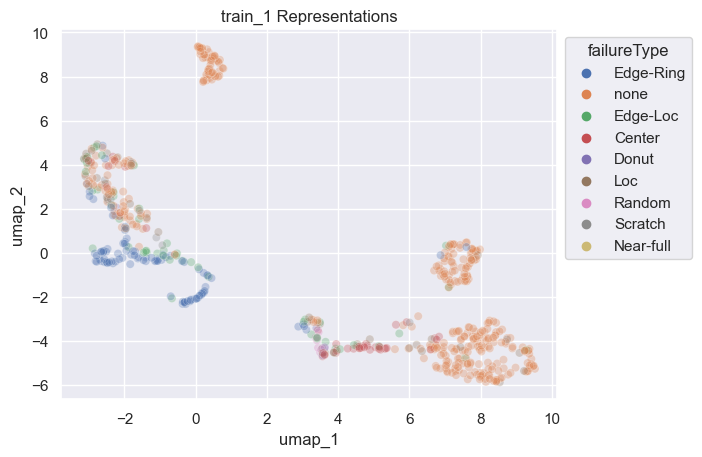

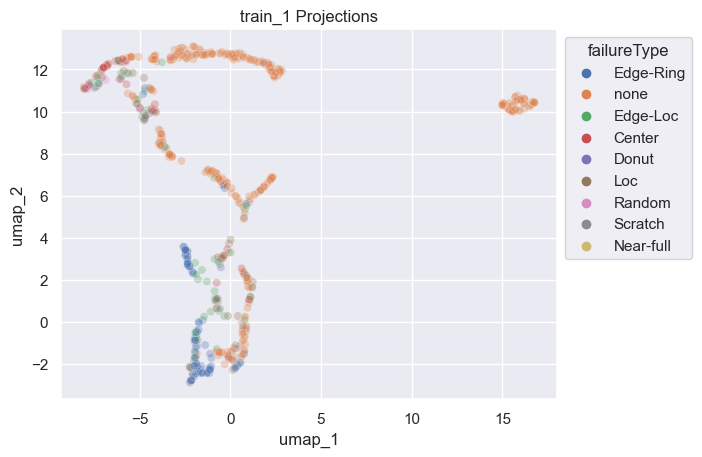

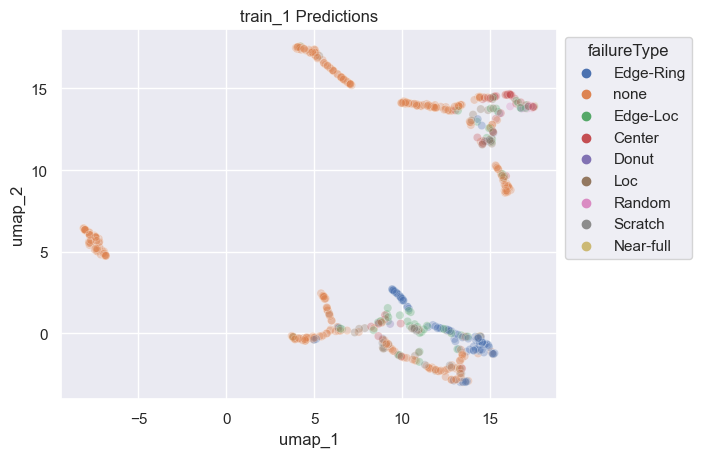

Extracting embeddings for train_10 data


 13%|█▎        | 840/6225 [00:13<01:26, 62.21it/s]


KeyboardInterrupt: 

In [ ]:
ckpt_path = "lightning_logs/r18_timm_25/checkpoints/epoch=24-step=19450.ckpt"
model = FastSiam.load_from_checkpoint(ckpt_path)
# Extract embeddings for each data split and save to file
save_dir = "../data/embeddings/fastsiam_r18_timm_25"
for name, data in datasets.items():
    print(f"Extracting embeddings for {name} data")
    extract_embeddings(model, data, save_dir, name=name)